# Introdução ao OCR - Parte 2

### Importando as bibliotecas necessárias

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Obtendo os dados de Captcha

In [16]:
# !curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip

!tar -xf captcha_images_v2.zip 

In [17]:
#!unzip -qq captcha_images_v2.zip # Caso a opção acima não funcione, ou esteja usando Unix-based systems

Exemplo baseado na documentação da Keras API e o exemplo dado em https://keras.io/examples/vision/captcha_ocr/

### Carregando imagens e metadados

In [18]:
# Path para o diretória
data_dir = Path("./captcha_images_v2/")

# Obtendo lista de imagens e informações das mesmas
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Número de imagens encontradas: ", len(images))
print("Número de labels encontrados: ", len(labels))
print("Número de caracteres únicos: ", len(characters))
print("Caracteres presentes: ", characters)

Número de imagens encontradas:  1040
Número de labels encontrados:  1040
Número de caracteres únicos:  19
Caracteres presentes:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [19]:
# Batch size para treino e validação
batch_size = 16

# Dimensões das imagens
img_width = 200
img_height = 50

# Fator de downsampling das amostras por blocos de convolução
# Temos 2 blocos de convolução e 2 de pooling (fator de downsampling 2)
# Portanto, o downsampling total tem um fator 4
downsample_factor = 4

# Tamanho máximo do captcha, obtido pelo máximo entre as amostras
max_length = max([len(label) for label in labels])
print(f"Tamanho máximo do captcha entre as amostras é: {max_length}")

Tamanho máximo do captcha entre as amostras é: 5


### Pré-processamento

In [20]:
# Mapeamento caracteres => inteiros
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

In [21]:
# Mapeamento inverso do acima
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [22]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Tamanho total do dataset
    size = len(images)
    # 2. Faz um array de índices e embaralha com shuffle = True
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Obtém tamanho das amostras de treino
    train_samples = int(size * train_size)
    # 4. Split para treino e validação
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Leitura da image
    img = tf.io.read_file(img_path)
    # 2. Decodificação e passagem para gray scale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convertendo para float no intervalo [0, 1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Mudando o shape do array para a dimensão desejada
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Vamos transpor a imagem uma vez que o análogo da 
    # variável temporal é a largura da imagem
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Mapeamento de caracteres => números
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Como nosso modelo precisa de 2 inputs, retornamos um Python Dict
    return {"image": img, "label": label}

In [23]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

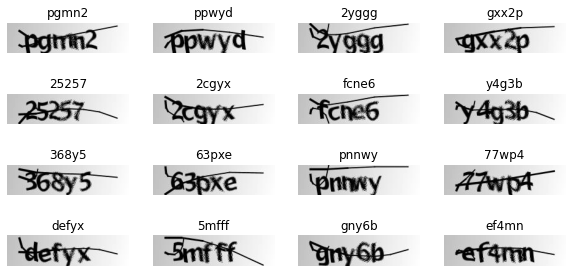

In [24]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

### Criando classe do modelo e carregando funções auxiliares

In [25]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Calcula o loss no treino e adiciona aos layers usando self.add_loss
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs do modelo
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # Primeiro bloco de convolução + maxpooling
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Segundo bloco de convolução + maxpooling
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # Como usamos 2 maxpoolings de stride = 2, temos um downsample
    # que reduz os feature maps em 4 vezes. Fazer o reshaping de acordo
    # antes de começar a parte de passagem do modelo pela RNN
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Layer de output
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Adicionando CTC (Connectionist temporal classification) layer para calcular o CTC Loss
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Definindo o modelo
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Definindo o otimizador
    opt = keras.optimizers.Adam()
    # Compila o modelo e retorna
    model.compile(optimizer=opt)
    return model


# Obtendo um resumo do modelo montado acima
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

### Treinando o modelo

In [29]:
epochs = 20
early_stopping_patience = 10
# Adicionando early stopping a partir do val_loss
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Treinando o modelo
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/20
59/59 [==============================] - 7s 120ms/step - loss: 0.1768 - val_loss: 0.1238
Epoch 2/20
59/59 [==============================] - 7s 114ms/step - loss: 0.2990 - val_loss: 0.1111
Epoch 3/20
59/59 [==============================] - 7s 116ms/step - loss: 0.1481 - val_loss: 0.0917
Epoch 4/20
59/59 [==============================] - 7s 118ms/step - loss: 0.1703 - val_loss: 0.1504
Epoch 5/20
59/59 [==============================] - 7s 116ms/step - loss: 0.0973 - val_loss: 0.1014
Epoch 6/20
59/59 [==============================] - 7s 118ms/step - loss: 0.0965 - val_loss: 0.1082
Epoch 7/20
59/59 [==============================] - 7s 124ms/step - loss: 0.0923 - val_loss: 0.0942
Epoch 8/20
59/59 [==============================] - 7s 116ms/step - loss: 0.1179 - val_loss: 0.0989
Epoch 9/20
59/59 [==============================] - 7s 116ms/step - loss: 0.0854 - val_loss: 0.0858
Epoch 10/20
59/59 [==============================] - 7s 117ms/step - loss: 0.0933 - val_loss: 0.0915

### Fazendo inferências

In [32]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# Função útil para decodificar o output da rede neural
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            4921

1/1 [==============================] - 0s 48ms/step


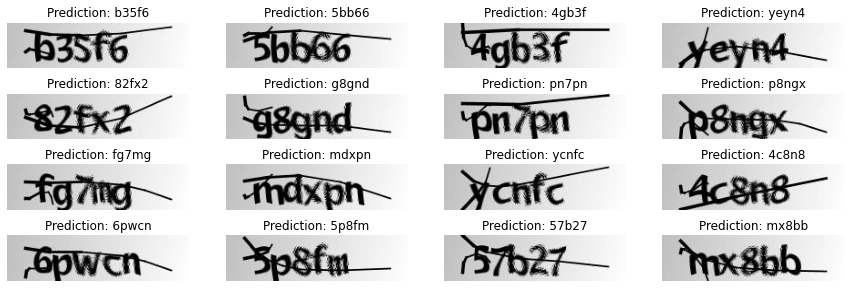

In [35]:
# Checando os resultados em alguns dados de validação
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

Exemplo a partir de https://keras.io/examples/vision/captcha_ocr/